# `nb01`: Build, compute, critique, repeat

![](./figures/nb01/boxloop.png)

In this course, we will approach data science problems using the scientific method. We will build models, compute results, and critique our work. We will repeat this process until we are satisfied with our results. This process is called the **Box's Loop**. Upcoming lectures will dive into each of these steps in more detail.

# Build 

In [1]:
import numpy as np

# Generative model
def simulate(v, alpha, dt=0.001, G=9.81):
    v_x = v * np.cos(alpha)
    v_y = v * np.sin(alpha)

    x = 0
    y = 1.5

    trajectory = [(x, y)]

    while y > 0:
        v_y += dt * -G
        x += dt * v_x
        y += dt * v_y 
        trajectory.append((x, y))

    return np.array(trajectory)


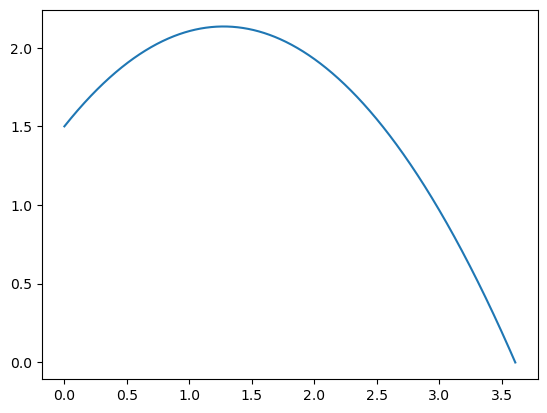

In [2]:
import matplotlib.pyplot as plt 

v = 5.0
alpha = np.pi / 4 

trajectory = simulate(v, alpha, dt=0.001)
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

In [3]:
# Probabilistic model
from scipy.stats import norm, uniform

def likelihood(v, alpha):
    trajectory = simulate(v, alpha)
    x = trajectory[-1, 0]
    return norm(loc=x, scale=0.5)

p_v = uniform(0, 10.)
p_alpha = uniform(0, np.pi / 2)

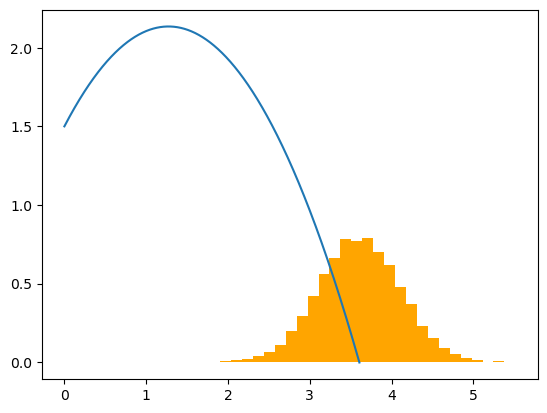

In [4]:
# p(x | v, alpha)
v = 5.0
alpha = np.pi / 4

trajectory = simulate(v, alpha)
plt.plot(trajectory[:, 0], trajectory[:, 1])

lk = likelihood(v, alpha)
xs = lk.rvs(10000)
plt.hist(xs, density=True, bins=30, color="orange")

plt.show()

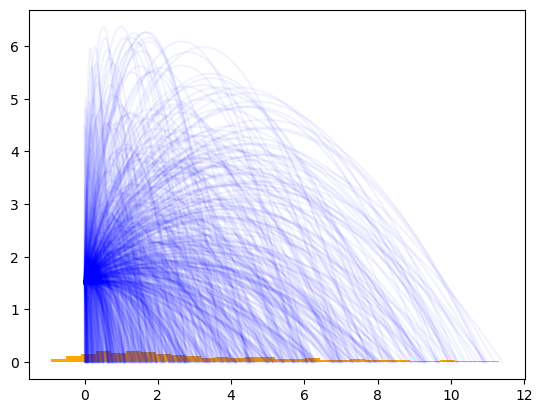

In [5]:
# p(x)
xs = []

for i in range(1000):
    v = p_v.rvs()
    alpha = p_alpha.rvs()

    trajectory = simulate(v, alpha)
    plt.plot(trajectory[:, 0], trajectory[:, 1], color="b", alpha=0.05)
    x = likelihood(v, alpha).rvs()
    xs.append(x)

plt.hist(xs, density=True, bins=30, color="orange")
plt.show()

# Data

In [6]:
v_true = 5.0
alpha_true = np.pi / 4.
x_obs = likelihood(v_true, alpha_true).rvs()

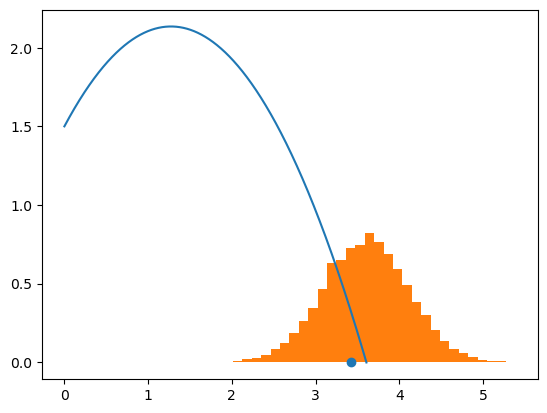

In [7]:
trajectory = simulate(v_true, alpha_true)
plt.plot(trajectory[:, 0], trajectory[:, 1])

lk = likelihood(v_true, alpha_true)
xs = lk.rvs(10000)
plt.hist(xs, density=True, bins=30)
plt.scatter([x_obs], [0.])
plt.show()

# Compute

In [8]:
# Point-valued estimate
from scipy.optimize import minimize

def log_likelihood(theta, x):
    v, alpha = theta
    lk = likelihood(v, alpha)
    return lk.logpdf(x)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([p_v.rvs(), p_alpha.rvs()])
soln = minimize(nll, initial, args=(x_obs,))
soln

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.22579135264488792
        x: [ 5.471e+00  1.026e+00]
      nit: 6
      jac: [ 7.153e-07 -5.454e-06]
 hess_inv: [[ 5.728e-01  7.780e-02]
            [ 7.780e-02  1.805e-02]]
     nfev: 30
     njev: 10

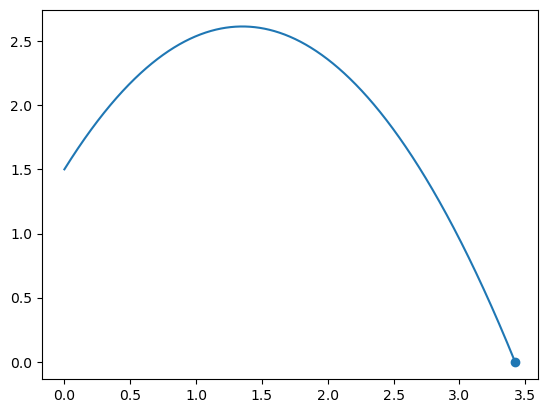

In [9]:
v_sol, alpha_sol = soln.x 

trajectory = simulate(v_sol, alpha_sol)
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.scatter([x_obs], [0.])
plt.show()

In [10]:
# Uncertainty estimation
def log_prior(theta):
    v, alpha = theta 
    return p_v.logpdf(v) + p_alpha.logpdf(alpha)

def log_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf 
    return lp + log_likelihood(theta, x)

In [11]:
import emcee
pos = soln.x + 0.1 * np.random.randn(10, 2)
nwalkers, ndim = pos.shape 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_obs,))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [01:31<00:00, 109.25it/s]


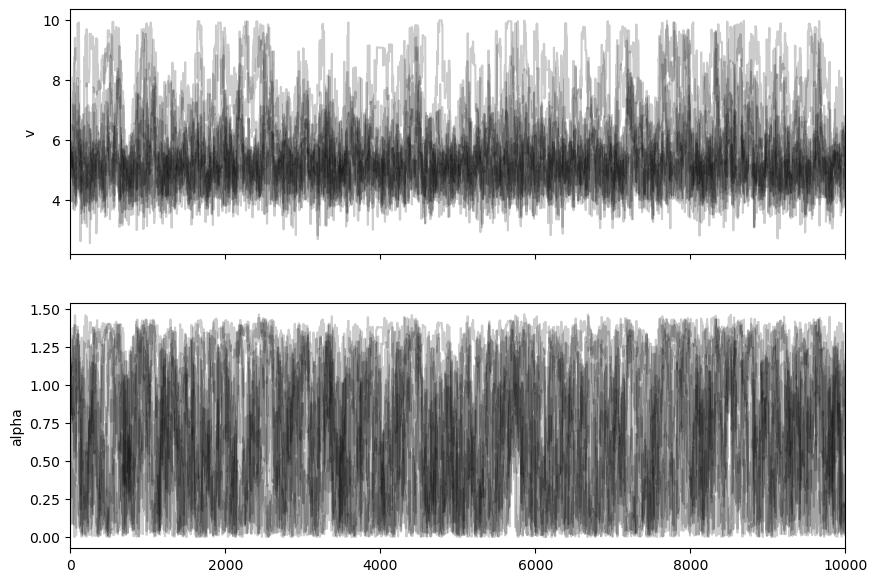

In [12]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["v", "alpha"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

plt.show()

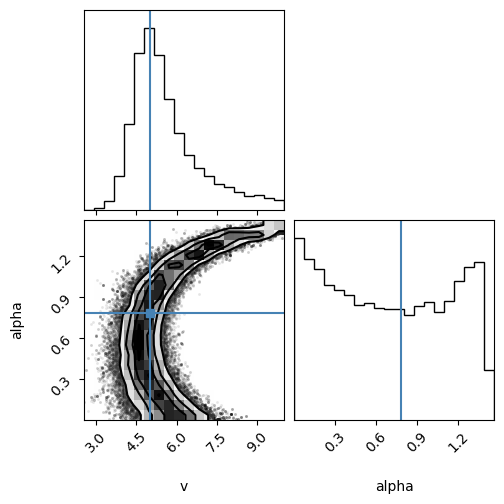

In [13]:
import corner
thetas = sampler.get_chain(flat=True)
fig = corner.corner(thetas, labels=labels, truths=[v_true, alpha_true])

# Critique

In [14]:
# Computational diagnostics 
tau = sampler.get_autocorr_time()
print(tau)

[128.19509488 116.58497672]


In [15]:
thetas = sampler.get_chain(flat=True, thin=50)
thetas.shape

(2000, 2)

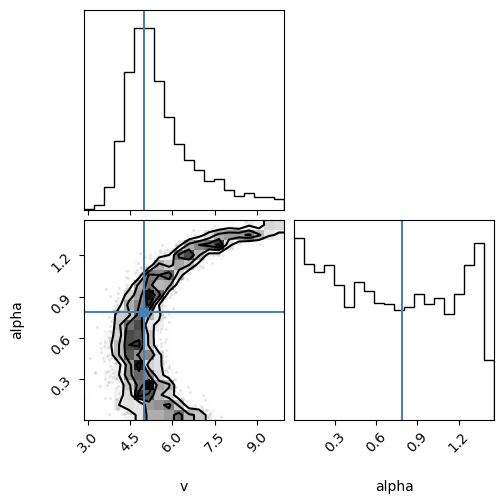

In [16]:
fig = corner.corner(thetas, labels=labels, truths=[v_true, alpha_true])

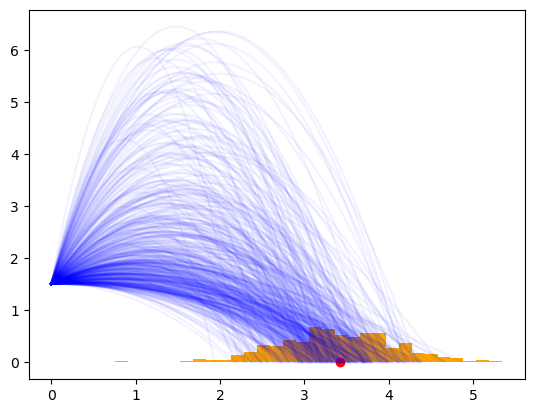

In [17]:
# Posterior predictive checks
# p(x | x_obs)
xs = []

for v, alpha in thetas[:500]:
    trajectory = simulate(v, alpha)
    plt.plot(trajectory[:, 0], trajectory[:, 1], color="b", alpha=0.05)
    x = likelihood(v, alpha).rvs()
    xs.append(x)

plt.hist(xs, density=True, bins=30, color="orange")
plt.scatter([x_obs], [0.], c="r")
plt.savefig("box-loop-ppc.png")
plt.show()

# Improve and repeat

- What if `x_obs=15`?
- What if the height of the pitcher is unknown?
- What if there is wind? 
- What if, maybe, there is wind?
- How to evaluate and compare models?